In [34]:
from lyricsgenius import Genius
import json
import re
from requests.exceptions import Timeout
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import api_key

In [442]:
token = api_key.token

In [443]:
genius = Genius(token)

In [444]:
genius.excluded_terms = ["(Remix)", "(Live)", "(Intro)"]

# 1. Getting data

In [445]:
def sanitizer(artist_name):
    
    sanitized_artist = ''.join(char if char.isalnum() or char in ('-', '_') else '_' for char in artist_name)
    return sanitized_artist

In [446]:
def get_lyrics(genius, artist, n_songs=25):

    sanitized_artist = sanitizer(artist)
    custom_filename = os.path.join("data", f"{sanitized_artist}.json")
    
    genius.timeout = 15
    genius.sleep_time = 5
    retries = 0
    while retries < 3:
        try:
            result = genius.search_artist(artist, max_songs=n_songs, sort="popularity")
            result.save_lyrics(filename=custom_filename, overwrite=True, sanitize=False)
            break
        except Timeout as e:
            retries += 1
            continue

In [447]:
artist = 'Pitbull'

In [448]:
get_lyrics(genius, artist)

Searching for songs by Pitbull...

Song 1: "Feel This Moment"
Song 2: "Timber"
Song 3: "Give Me Everything"
Song 4: "Hotel Room Service"
Song 5: "Options"
"Time of Our Lives" is not valid. Skipping.
Song 6: "International Love"
Song 7: "We Are One (Ole Ola)"
Song 8: "Fireball"
Song 9: "I Know You Want Me (Calle Ocho)"
Song 10: "Rain Over Me"
Song 11: "El Taxi"
Song 12: "Culo"
Song 13: "Fun"
Song 14: "Hey Baby (Drop It to the Floor)"
"Gasolina (Remix)" is not valid. Skipping.
Song 15: "Greenlight"
Song 16: "Don’t Stop the Party"
Song 17: "Back in Time"
"Don’t Mind (Remix)" is not valid. Skipping.
"Live It Up" is not valid. Skipping.
"Mr. Worldwide (Intro)" is not valid. Skipping.
Song 18: "Mentirosa"
Song 19: "Ocean To Ocean"
"Watagatapitusberry (Remix)" is not valid. Skipping.
Song 20: "Hold Up Wait A Minute"
Song 21: "Welcome To Dade County (Lil Wayne Diss)"
Song 22: "Go Girl"
Song 23: "The Anthem"
Song 24: "3 to Tango"
"Bojangles (Remix)" is not valid. Skipping.
Song 25: "Wild Wild L

In [449]:
def load_lyrics(artist):
    
    sanitized_artist = sanitizer(artist)
    
    with open(f'data/{sanitized_artist}.json') as f:
        data = json.load(f)
    
    return data

In [450]:
data = load_lyrics(artist)

In [451]:
songs = []

for song in data['songs']:
    songs.append((song['title'], song['lyrics']))

In [452]:
songs[0]

('Feel This Moment',
 "88 ContributorsTranslationsΕλληνικάFeel This Moment Lyrics[Intro: Pitbull]\nAsk for money and get advice\nAsk for advice, get money twice\nI'm from the dirty, but that chico nice\nY'all call it a moment, I call it life\n\n[Pre-Chorus: Christina Aguilera]\nOne day while my light is glowin'\nI'll be in my castle golden\nBut until the gates are open\nI just wanna feel this moment\n\n[Chorus: Christina Aguilera]\nWoah-oh-oh-oh\nI just wanna feel this moment\nWoah-oh-oh-oh\nI just wanna feel this moment\n\n[Interlude: Pitbull & Christina Aguilera]\nMr. Worldwide\nChristina Aguilera\nOye, mamita, come on\nDale, que la cosa está rica, jajaja (I just wanna feel this moment)\n\n[Drop: Pitbull]\nWoo\nFeel this moment\nYou might also like[Verse 1: Pitbull]\nReporting live from the tallest building in Tokyo\nLong ways from them hard ways, filled with zoes and oye's\nDade County always, 3-0-5, all day\nNow, baby, we can parlay or, baby, we can party (Heh)\nShe read books, esp

# 2. Analysis

## 2.1. Preprocessing and vectorization

In [453]:
def preprocess_lyrics(lyrics):
    
    lyrics= re.sub(r'\d+Embed$', '', lyrics)
    lyrics=re.sub(r'^.*?\n', '', lyrics, flags=re.DOTALL)
    lyrics=re.sub(r'\[.+?\]', '', lyrics)
    lyrics = re.sub(r"[^a-zA-Z'\d\s]", '', lyrics).lower()
    
    return lyrics

In [454]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

In [455]:
from sklearn.feature_extraction.text import CountVectorizer

In [456]:
tokenizer = LemmaTokenizer()

In [457]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if (len(t) > 1)] 

In [458]:
tokenizer=LemmaTokenizer()

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

In [461]:
stopwords = stopwords.words('english')

In [501]:
stop_words_clean = tokenizer(' '.join(stopwords)) + ["'m"]

In [502]:
vectorizer_1 = CountVectorizer(preprocessor=preprocess_lyrics, tokenizer=tokenizer, min_df=2, ngram_range=(1,3), stop_words=stop_words_clean)

In [ ]:
X = vectorizer_1.fit_transform([song[1] for song in songs])

In [510]:
tokens = vectorizer_1.get_feature_names_out()
tokens_count = X.toarray().sum(axis=0)

In [512]:
df = pd.DataFrame({'Term':tokens, 'Occurences':tokens_count})
df.sort_values(by='Occurences', ascending=False, inplace=True)
df_top = df.head(25)
df_top.head()

,Term,Occurences
25,baby,211
296,like,115
238,hey,113
282,let,101
395,one,101


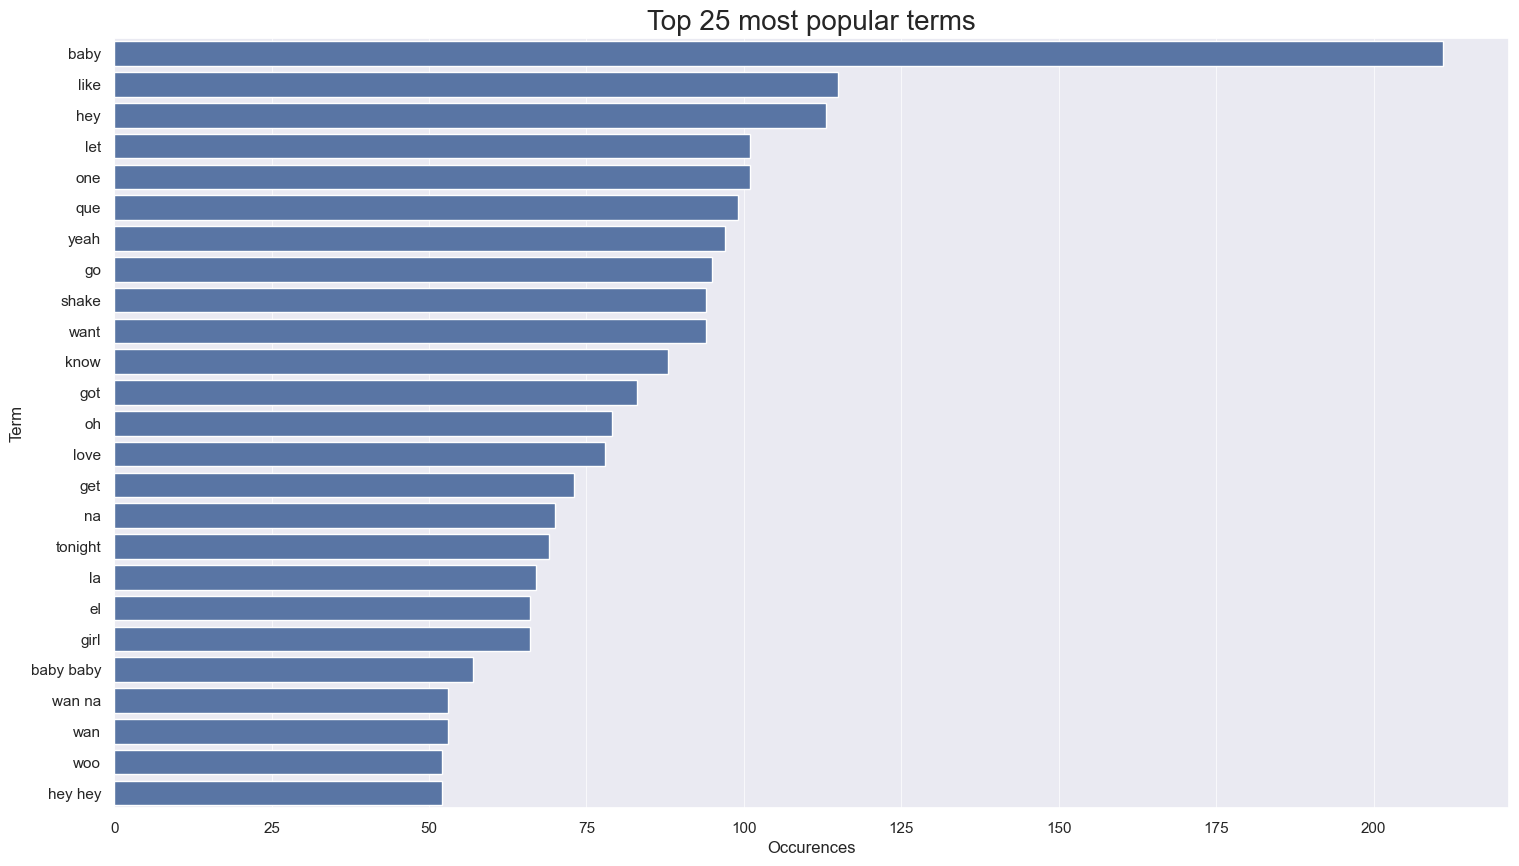

In [535]:
df_top = df_top.sort_values(by='Occurences', ascending=False)

sns.set_style("darkgrid")
plt.figure(figsize=(18, 10))
sns.barplot(x='Occurences', y='Term', data=df_top, color=sns.color_palette()[0]) #palette='viridis')  # Change 'viridis' to the desired color palette
plt.grid(axis='x', linewidth=0.5, linestyle='-')
plt.title('Top 25 most popular terms', fontsize=20)
plt.ylabel('Term')
plt.xlabel('Occurences')
plt.savefig('popularity.png')
plt.show()

## 2.2. TF-IDF transformation

In [515]:
from sklearn.feature_extraction.text import TfidfTransformer

In [516]:
transformer = TfidfTransformer()

In [517]:
X_tfidf = transformer.fit_transform(X)

In [518]:
X_tfidf.toarray()

array([[0.02837901, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02347342, 0.        , 0.02749191, ..., 0.        , 0.        ,
        0.        ],
       [0.05905156, 0.        , 0.04149647, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19190798, 0.07564382,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09334674, ..., 0.        , 0.        ,
        0.        ]])

In [521]:
titles = [song[0] for song in songs]

In [522]:
tfidf_df = pd.DataFrame(X_tfidf.toarray(), index=titles, columns=vectorizer_1.get_feature_names_out())

In [523]:
tfidf_df.head()

,'cause,'cause know,'em,'til,305,305 'til,ah,ahah,ahora,ai,...,yeah wan,yeah wan na,yeah yeah,yeah yeah yeah,yellow,yes,yet,yo,yo te,young
Feel This Moment,0.028379,0.0,0.000000,0.000000,0.029833,0.0,0.0,0.048201,0.0,0.000000,...,0.048201,0.048201,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
Timber,0.023473,0.0,0.027492,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.042731,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
Give Me Everything,0.059052,0.0,0.041496,0.041496,0.000000,0.0,0.0,0.000000,0.0,0.010750,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.020059,0.000000,0.0,0.0
Hotel Room Service,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.012340,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.017975,0.0,0.0
Options,0.053992,0.0,0.063235,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.147430,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [524]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})

In [526]:
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)
top_tfidf['rank'] = top_tfidf.groupby('document')['tfidf'].cumcount() + 1

In [527]:
pd.pivot_table(top_tfidf, values='term', index='document', columns='rank', aggfunc=lambda x: x.iloc[0])

rank,1,2,3,4,5,6,7,8,9,10
document,,,,,,,,,,
3 to Tango,three,round,take,two,like like,one,like,let get,two one,business
Back in Time,baby,back,oh,sweet,let,excuse,let make,make movie,baby let,movie
Culo,culo,hey,est,hey hey,rica,tan,hey hey hey,que,si,el favor
Don’t Stop the Party,yeah yeah,yeah,pare,yeah yeah yeah,party,stop,ah,loose,la,que
El Taxi,todo,ella,de,el,la,para,lo,pa,yo,est
Feel This Moment,feel,wan,wan na,na,c'mon,day,light,open,money,difference
Fireball,takin,baby baby,baby,fire,back,tell,roof,come,said,little
Fun,body,come,tonight,wan,wan na,'til,baby,oh,na,woo
Give Me Everything,tonight,give everything,everything,hey,give,want tonight,want,excuse,baby,get


In [500]:
top_tfidf[top_tfidf['term'].str.contains('baby')]

,document,term,tfidf,rank
10112,Back in Time,baby,0.579760,1
10475,Back in Time,oh baby,0.309863,2
10123,Back in Time,baby let,0.154931,8
4445,Fireball,baby baby,0.546314,2
4442,Fireball,baby,0.341156,3
4443,Fireball,baby 'm,0.096531,8
7592,Fun,baby,0.180333,7
1292,Give Me Everything,baby,0.088712,10
8444,Hey Baby (Drop It to the Floor),hey baby,0.411166,1
8222,Hey Baby (Drop It to the Floor),baby,0.400861,2


## 2.3. Similarity between songs

In [529]:
from sklearn.metrics.pairwise import cosine_similarity

In [531]:
cosine_sim_matrix = cosine_similarity(X_tfidf, X_tfidf)

In [532]:
cosine_sim_df = pd.DataFrame(cosine_sim_matrix)
cosine_sim_df.columns = songs_titles
cosine_sim_df.index = songs_titles
cosine_sim_df.head()

,Feel This Moment,Timber,Give Me Everything,Hotel Room Service,Options,International Love,We Are One (Ole Ola),Fireball,I Know You Want Me (Calle Ocho),Rain Over Me,...,Don’t Stop the Party,Back in Time,Mr. Worldwide (Intro),Mentirosa,Ocean To Ocean,Watagatapitusberry (Remix),Hold Up Wait A Minute,Welcome To Dade County (Lil Wayne Diss),Go Girl,The Anthem
Feel This Moment,1.000000,0.042219,0.079125,0.086179,0.080245,0.118552,0.065259,0.054891,0.037897,0.068795,...,0.109643,0.122172,0.055943,0.114849,0.036898,0.078107,0.033657,0.041669,0.056971,0.047684
Timber,0.042219,1.000000,0.038108,0.075896,0.063511,0.124566,0.112260,0.017240,0.025717,0.095666,...,0.022484,0.103439,0.032587,0.020372,0.027343,0.016597,0.032292,0.025616,0.151714,0.075617
Give Me Everything,0.079125,0.038108,1.000000,0.040936,0.103276,0.052113,0.126304,0.089550,0.111499,0.055031,...,0.058902,0.133374,0.018282,0.038725,0.041667,0.006024,0.027502,0.033471,0.046561,0.075460
Hotel Room Service,0.086179,0.075896,0.040936,1.000000,0.018641,0.017290,0.024530,0.014409,0.062564,0.033503,...,0.025874,0.034426,0.017077,0.101807,0.044946,0.011546,0.033426,0.066453,0.123663,0.017564
Options,0.080245,0.063511,0.103276,0.018641,1.000000,0.075521,0.160711,0.234607,0.077838,0.082379,...,0.049115,0.246307,0.036964,0.142757,0.062076,0.020521,0.075390,0.030195,0.085530,0.108047


In [ ]:
cmap = sns.cm.rocket_r
sns.set(font_scale=1)
plt.figure(figsize=(20,10))
ax = sns.heatmap(cosine_sim_df.round(decimals=2), annot=True, cmap = cmap, vmin=0, vmax=1)
plt.title('Podobieństwo między dokumentami', fontsize = 20)
plt.show()

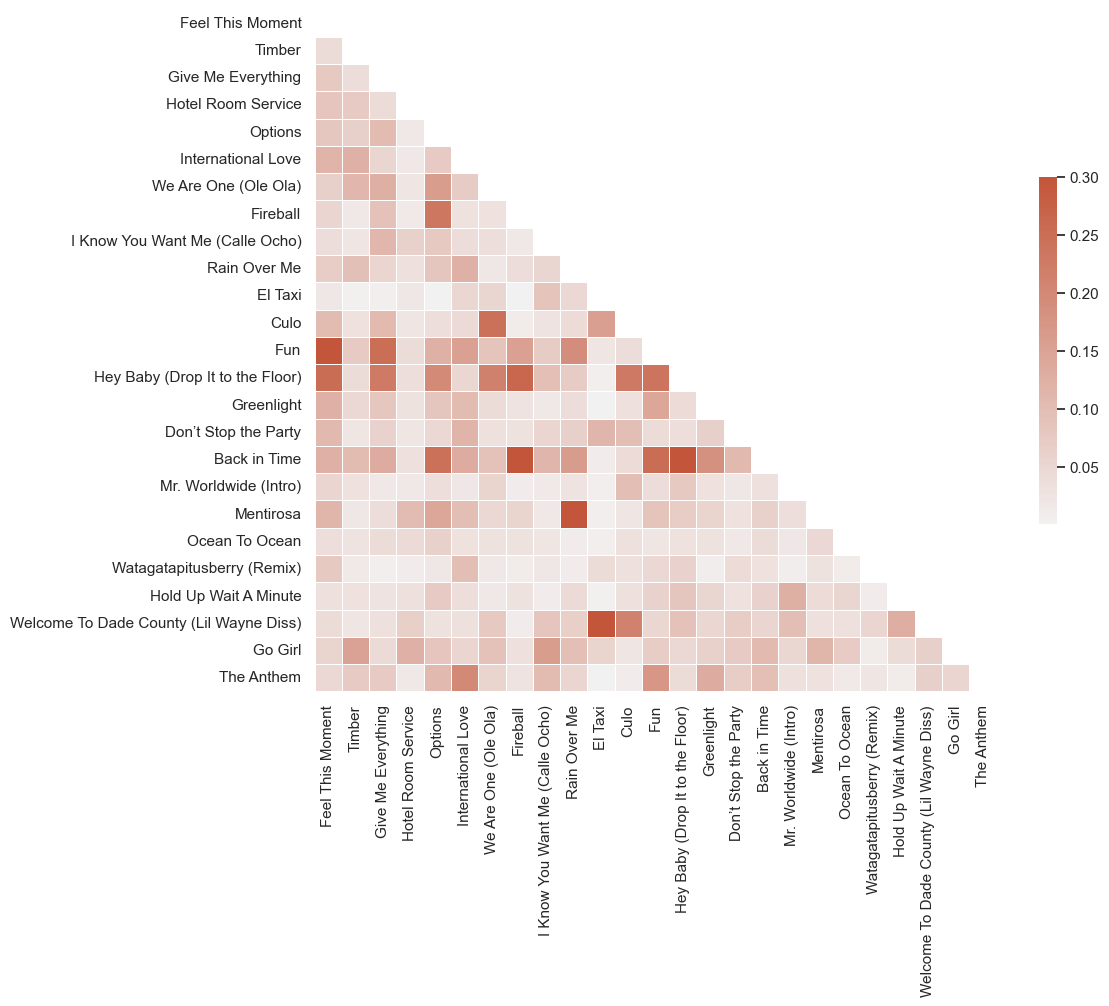

In [537]:
sns.set_theme(style="white")

# # Generate a large random dataset
# rs = np.random.RandomState(33)
# d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                  columns=list(ascii_letters[26:]))

# Compute the correlation matrix
# corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cosine_sim_matrix))
               #, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cosine_sim_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heatmap.png', bbox_inches='tight')

## 5. Clustering

In [148]:
from sklearn.cluster import KMeans

Find by GridSearch best set of hyperparameters

In [210]:
kmeans = KMeans(
    n_clusters=5,
    max_iter=100,
    n_init=5
)

In [211]:
preds= kmeans.fit_predict(X_tfidf)
preds

array([3, 3, 1, 3, 1, 3, 1, 1, 2, 3, 4, 4, 1, 2, 3, 2, 1, 2, 0, 2, 4, 1,
       2, 0, 4])

In [212]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([2, 7, 6, 6, 4], dtype=int64))

In [214]:
for i in range(len(songs_2d)):
    print(preds[i], songs_titles[i])

3 Feel This Moment
3 Timber
1 Give Me Everything
3 Hotel Room Service
1 Options
3 International Love
1 We Are One (Ole Ola)
1 Fireball
2 I Know You Want Me (Calle Ocho)
3 Rain Over Me
4 El Taxi
4 Culo
1 Fun
2 Hey Baby (Drop It to the Floor)
3 Greenlight
2 Don’t Stop the Party
1 Back in Time
2 Mr. Worldwide (Intro)
0 Mentirosa
2 Ocean To Ocean
4 Watagatapitusberry (Remix)
1 Hold Up Wait A Minute
2 Welcome To Dade County (Lil Wayne Diss)
0 Go Girl
4 The Anthem


In [215]:
kmeans.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0056354 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01333016, 0.        , 0.01011081, ..., 0.00444339, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00289847,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00771913]])

In [216]:
original_space_centroids = kmeans.cluster_centers_

In [217]:
original_space_centroids.argsort()

array([[   0, 1054, 1053, ...,  573,  563, 1255],
       [   0, 1009, 1005, ..., 1412, 1655,   80],
       [1666,  779,  778, ..., 1572, 1412,  782],
       [   0,  997,  996, ..., 1412,   75, 1018],
       [   0, 1013, 1012, ...,  829, 1575,  422]], dtype=int64)

In [218]:
original_space_centroids.argsort()[:, ::-1]

array([[1255,  563,  573, ..., 1053, 1054,    0],
       [  80, 1655, 1412, ..., 1005, 1009,    0],
       [ 782, 1412, 1572, ...,  778,  779, 1666],
       [1018,   75, 1412, ...,  996,  997,    0],
       [ 422, 1575,  829, ..., 1012, 1013,    0]], dtype=int64)

In [219]:
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [220]:
order_centroids

array([[1255,  563,  573, ..., 1053, 1054,    0],
       [  80, 1655, 1412, ..., 1005, 1009,    0],
       [ 782, 1412, 1572, ...,  778,  779, 1666],
       [1018,   75, 1412, ...,  996,  997,    0],
       [ 422, 1575,  829, ..., 1012, 1013,    0]], dtype=int64)

In [224]:
original_space_centroids[1][1412]

0.13677991164928596

In [225]:
terms = vectorizer.get_feature_names_out()

for i in range(5):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}: {original_space_centroids[i][ind]:.4f} ", end="")
    print()

Cluster 0: shake: 0.4582 girl: 0.2540 go: 0.1730 them: 0.1446 but: 0.1363 friends: 0.1289 mentirosa: 0.1208 ho: 0.1057 just: 0.1013 you: 0.0999 
Cluster 1: baby: 0.1689 you: 0.1483 the: 0.1368 tonight: 0.1284 ole: 0.1107 it: 0.0928 re: 0.0859 we: 0.0780 bringin: 0.0653 my: 0.0616 
Cluster 2: la: 0.1657 the: 0.1303 want: 0.1137 you: 0.1123 they: 0.0961 me: 0.0892 to: 0.0889 dade: 0.0809 worldwide: 0.0787 yeah: 0.0779 
Cluster 3: oh: 0.4359 ay: 0.1835 the: 0.1055 moment: 0.0964 hotel: 0.0870 international: 0.0837 wee: 0.0801 you: 0.0753 me: 0.0729 light: 0.0707 
Cluster 4: el: 0.1807 watagatapitusberry: 0.1619 lo: 0.1462 hey: 0.1449 cho: 0.1389 que: 0.1317 tremendo: 0.1163 culo: 0.1054 loca: 0.0980 tiene: 0.0873 


### LSA

## 6. Topic extraction